In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import re

from sklearn.linear_model import LinearRegression
import seaborn


pd.set_option('display.max_columns', 30)

### ここだけ手動で設定

In [2]:
subject_name_list = ["kumakura","kim","souma","fujii","tubota","toki"]
phase_name_list = ["rest", "practice", "boredom", "flow", "ultra", "overload"]

In [3]:
pathes = glob.glob("/Users/miyakooti/repositories/arai_MATLAB_program/csv/?_*/HRV_and_PLI.csv")
pathes.sort()
pathes

['/Users/miyakooti/repositories/arai_MATLAB_program/csv/0_kumakura/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/1_kim/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/2_souma/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/3_fujii/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/4_tubota/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/5_toki/HRV_and_PLI.csv']

In [4]:
df = pd.read_csv(f"{pathes[0]}",index_col=0).fillna(0) 
# アンケートは一部のフェーズでしか取ってないので0で補完
df

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,...,hf_nu,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,73.678878,814.344647,40.280560,20.440067,36.813667,0.617801,0.196335,30,26.031042,50.702371,4146.385678,0.513409,0.320626,363.483291,206.384215,...,70.044015,0.47038,0.71824,0.53059,0.78305,0.35243,0.28658,0.39018,0.504493,0.677293,0.0,0.0,0.0,0.0,0.00
practice,75.523947,794.450000,31.370784,17.631999,31.337680,0.534050,0.082437,22,22.158335,38.395387,2672.797416,0.577109,0.366667,649.675157,351.846586,...,37.094976,0.27293,0.38358,0.47002,0.54056,0.34591,0.32768,0.19776,0.362634,0.464720,0.0,0.0,0.0,0.0,0.00
boredom,75.368816,796.085213,41.400093,17.968812,33.557870,0.610553,0.130653,24,23.728891,53.486937,3987.264510,0.443639,0.346315,232.041729,290.761023,...,53.468079,0.28649,0.43996,0.43761,0.54694,0.17318,0.15961,0.23876,0.326079,0.474837,2.0,2.0,5.0,2.0,2.75
flow,79.462990,755.068493,45.496886,17.074905,30.303453,0.552369,0.093516,30,21.427739,60.626869,4081.232643,0.353436,0.131944,744.117782,227.008970,...,24.144844,0.26200,0.42757,0.43541,0.37519,0.66146,0.52691,0.25446,0.420429,0.412723,7.0,7.0,7.0,7.0,7.00
ultra,80.444654,745.854406,64.168076,19.123863,31.929731,0.526923,0.130769,56,22.573323,87.768671,6224.219338,0.257191,0.133333,1666.610672,311.682250,...,27.775260,0.65670,0.75545,0.80386,0.77300,0.86585,0.81846,0.60434,0.753951,0.777437,5.0,7.0,6.0,7.0,6.25
overload,75.991495,789.562044,39.822757,19.241337,33.166542,0.551220,0.124390,30,23.452286,51.274384,3777.769872,0.457388,0.123263,682.892676,308.792854,...,27.176745,0.12267,0.28812,0.42067,0.50908,0.24092,0.20799,0.15147,0.277274,0.405957,7.0,6.0,2.0,6.0,5.25


In [5]:
df = df[["bpm", "ibi", "lf", "hf","lf/hf","FC3","FC4","FCz","mean_3ch","questionnaire_average"]]
df

,bpm,ibi,lf,hf,lf/hf,FC3,FC4,FCz,mean_3ch,questionnaire_average
rest,73.678878,814.344647,206.384215,482.573993,0.427674,0.71824,0.53059,0.78305,0.677293,0.00
practice,75.523947,794.450000,351.846586,207.483280,1.695783,0.38358,0.47002,0.54056,0.464720,0.00
boredom,75.368816,796.085213,290.761023,334.102552,0.870275,0.43996,0.43761,0.54694,0.474837,2.75
flow,79.462990,755.068493,227.008970,72.257397,3.141671,0.42757,0.43541,0.37519,0.412723,7.00
ultra,80.444654,745.854406,311.682250,119.862745,2.600326,0.75545,0.80386,0.77300,0.777437,6.25
overload,75.991495,789.562044,308.792854,115.237706,2.679616,0.28812,0.42067,0.50908,0.405957,5.25


### まずフェーズごとの回帰をする

In [6]:
df = df.loc[["flow"]] # dataFrameとして取り出したいときはこっち
# df.loc["flow"] # Seriesとして取り出したいときはこっち

test = pd.concat([df,df,df], axis=0)
test




,bpm,ibi,lf,hf,lf/hf,FC3,FC4,FCz,mean_3ch,questionnaire_average
flow,79.46299,755.068493,227.00897,72.257397,3.141671,0.42757,0.43541,0.37519,0.412723,7.0
flow,79.46299,755.068493,227.00897,72.257397,3.141671,0.42757,0.43541,0.37519,0.412723,7.0
flow,79.46299,755.068493,227.00897,72.257397,3.141671,0.42757,0.43541,0.37519,0.412723,7.0


In [7]:
# データセット作成

for i,path in enumerate(pathes):
    if "kim" in path:
        continue
    df = pd.read_csv(path,index_col=0).fillna(0)
    df = df[["bpm", "ibi", "lf", "hf","lf/hf","FC3","FC4","FCz","mean_3ch","questionnaire_average"]]
    df = df.loc[["flow"]] # seriesとして取り出したいときはこっち
    if i == 0:
        flow_dataset = df
    flow_dataset = pd.concat([flow_dataset, df], axis=0)
    
flow_dataset

,bpm,ibi,lf,hf,lf/hf,FC3,FC4,FCz,mean_3ch,questionnaire_average
flow,79.462990,755.068493,227.008970,72.257397,3.141671,0.42757,0.43541,0.37519,0.412723,7.00
flow,79.462990,755.068493,227.008970,72.257397,3.141671,0.42757,0.43541,0.37519,0.412723,7.00
flow,67.177316,893.158637,479.902818,550.589306,0.871617,0.26153,0.31830,0.55653,0.378787,5.75
flow,71.024566,844.778135,445.662097,228.941761,1.946618,0.44200,0.50466,0.64272,0.529793,6.25
flow,87.377865,686.672760,428.892008,114.920183,3.732086,0.44068,0.47894,0.53998,0.486533,6.25
flow,72.643550,825.950820,449.168624,160.526534,2.798096,0.66217,0.65861,0.71527,0.678683,5.75


LinearRegression()

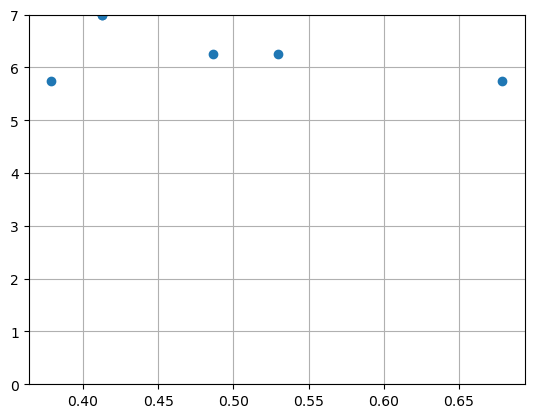

In [10]:
# x = flow_dataset[["bpm", "ibi", "lf", "hf","lf/hf","FC3","FC4","FCz","mean_3ch"]]
x = flow_dataset[["mean_3ch"]]
y = flow_dataset[["questionnaire_average"]]

plt.scatter(x,y)
plt.ylim(0, 7)
plt.grid(True)

lr_model = LinearRegression()
lr_model.fit(x,y)


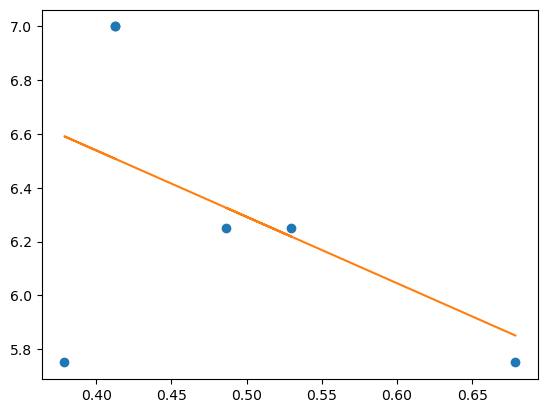

モデル関数の回帰変数 w1: -2.470
モデル関数の切片 w2: 7.527
y= -2.470x + 7.527
決定係数 R^2：  0.2359727114474508


In [9]:
plt.plot(x, y, 'o')
plt.plot(x, lr_model.predict(x), linestyle="solid")
plt.show()

print('モデル関数の回帰変数 w1: %.3f' %lr_model.coef_)
print('モデル関数の切片 w2: %.3f' %lr_model.intercept_)
print('y= %.3fx + %.3f' % (lr_model.coef_ , lr_model.intercept_))
print('決定係数 R^2： ', lr_model.score(x, y))

### statsmodelsでもやってみる
- https://ai-trend.jp/programming/python/linearregression/

In [11]:
import statsmodels.api as sm

### 線形単回帰分析

                              OLS Regression Results                             
Dep. Variable:     questionnaire_average   R-squared:                       0.296
Model:                               OLS   Adj. R-squared:                  0.120
Method:                    Least Squares   F-statistic:                     1.682
Date:                   Thu, 12 Jan 2023   Prob (F-statistic):              0.264
Time:                           14:30:29   Log-Likelihood:                -3.4640
No. Observations:                      6   AIC:                             10.93
Df Residuals:                          4   BIC:                             10.51
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1416 

/Users/miyakooti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


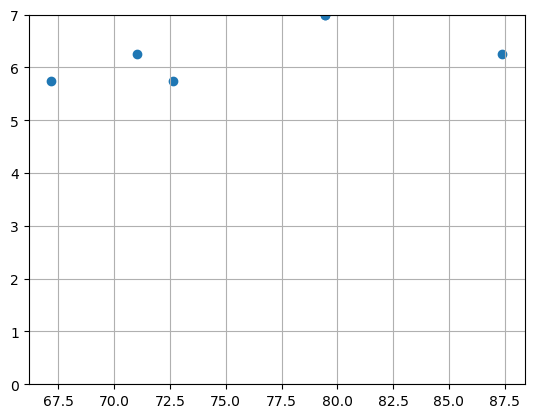

In [15]:
x = flow_dataset[["bpm"]]
y = flow_dataset[["questionnaire_average"]]

plt.scatter(x,y)
plt.ylim(0, 7)
plt.grid(True)

#全要素が1の列を説明変数の先頭に追加（絶対必要！！）
X = sm.add_constant(x)
 
#モデルの設定
model = sm.OLS(y, X)
 
#回帰分析の実行
results = model.fit()
 
#結果の詳細を表示
print(results.summary())

### 線形重回帰分析（マルチこに気をつけよう）

In [21]:
x = flow_dataset[["bpm", "ibi","mean_3ch"]]
y = flow_dataset[["questionnaire_average"]]

#全要素が1の列を説明変数の先頭に追加,切片をつけるために必ず必要
X = sm.add_constant(x)
 
#モデルの設定
model = sm.OLS(y, X)
 
#回帰分析の実行
results = model.fit()
 
#結果の詳細を表示
print(results.summary())

## いい結果のように思えるが、多重共線性により偽の有意性が出てしまっている

                              OLS Regression Results                             
Dep. Variable:     questionnaire_average   R-squared:                       0.977
Model:                               OLS   Adj. R-squared:                  0.942
Method:                    Least Squares   F-statistic:                     28.05
Date:                   Thu, 12 Jan 2023   Prob (F-statistic):             0.0346
Time:                           14:34:34   Log-Likelihood:                 6.7720
No. Observations:                      6   AIC:                            -5.544
Df Residuals:                          2   BIC:                            -6.377
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.4892 

/Users/miyakooti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
